In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import datetime
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
abs_path = '/content/drive/My Drive/Coder_CaHop/Data/raw/null_normalized_data'
ads_info_data = pd.read_csv(abs_path + '/ads_info.csv', index_col=0)
ads_params_data = pd.read_csv(abs_path + '/ads_params.csv', index_col=0)
ads_stats_data = pd.read_csv(abs_path + '/ads_stats.csv', index_col=0)

In [0]:
data = pd.read_csv('/home/rakul/Documents/data/null_normalized_data/ads_stats.csv', index_col=0)
data.head()

,adlist_id,adplacement,adposition,adsource,app_os_name,app_os_version,app_version,browser_viewheight,browser_viewwidth,event_client_time,...,filter_price,filter_region_id,filter_type,lead_type,page_name,page_number,page_platform,page_referer,tagging_key,user_fingerprint
0,62548762,default,13,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:05:19.000,...,NaN,3017,NaN,NaN,ADLISTING,4,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
1,62547858,default,11,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:07:02.000,...,NaN,3017,NaN,NaN,ADLISTING,6,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
2,62547636,default,3,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:07:48.000,...,NaN,3017,NaN,NaN,ADLISTING,7,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
3,62546151,default,19,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:08:53.000,...,NaN,3017,NaN,NaN,ADLISTING,10,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
4,62002718,default,4,classifyad,NaN,12.1.4,3.6.8973,667,667,2019-08-24 07:26:06.000,...,NaN,3017,NaN,NaN,ADLISTING,13,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631


In [0]:
data.columns

Index(['adlist_id', 'adplacement', 'adposition', 'adsource', 'app_os_name',
       'app_os_version', 'app_version', 'browser_viewheight',
       'browser_viewwidth', 'event_client_time', 'event_name',
       'event_server_time', 'event_type', 'filter_brand', 'filter_category_id',
       'filter_keyword', 'filter_model', 'filter_price', 'filter_region_id',
       'filter_type', 'lead_type', 'page_name', 'page_number', 'page_platform',
       'page_referer', 'tagging_key', 'user_fingerprint'],
      dtype='object')

**Observation:** Dataset includes bahavior of only 79 users in Chotot.

In [0]:
data['user_fingerprint'].nunique()

79

**Observation:** A wide range of platforms are used to visit the page. However, we can divide them into two device groups: desktop and mobile.

**Note:** We decide to ignore tablet and laptop with IOS for the sake of simplicity.

In [0]:
data['page_platform'].unique()

array(['IOS', 'ANDROID', 'MOBILE_SITE', 'DESKTOP'], dtype=object)

In [0]:
def get_page_device(page_platform):
    if page_platform != 'DESKTOP':
        page_platform = 'MOBILE'
    return page_platform

data['page_device'] = data['page_platform'].apply(get_page_device)

**Question:** Which type of device users use the most?

**Observation:** Considering that a user can create more than one event per visit, we then group users by user_fingerprint to eliminate duplicate values.

In [0]:
unique_data = data.groupby(by='user_fingerprint').agg(lambda x: list(set(x)))

In [0]:
unique_data['page_device'].value_counts()

MOBILE     75
DESKTOP     4
Name: page_device, dtype: int64

In [0]:
unique_data['page_device'] = unique_data['page_device'].apply(lambda lst: lst[0])

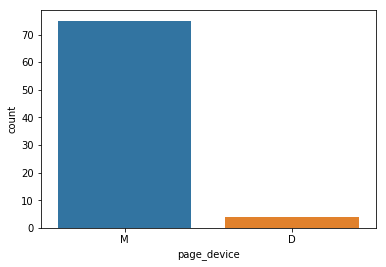

In [0]:
sns.countplot(x='page_device', data=unique_data);

**Observation:** Data set is high imbalanced with 97% of loading event and remaining 3% of clicking event. As you might expected, most of events created by mobile users.

In [0]:
data['event_type'].value_counts() / data.shape[0]

LOAD     0.976131
CLICK    0.023869
Name: event_type, dtype: float64

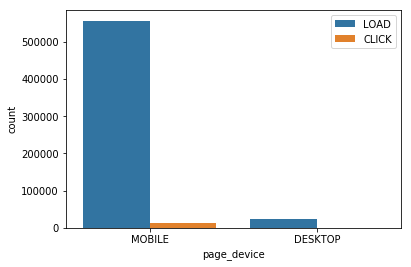

In [0]:
sns.countplot(x='page_device', hue='event_type', data=data);
plt.legend(loc='upper right');

**Thus, we decide to develop a mobile app.**

**Question:** To optimize user experience, we must care about aspect ratio of their browsers.

In [0]:
mobile_data = data[data['page_device'] == 'MOBILE']

In [0]:
def get_browser_ratio(row):
    width = row['browser_viewwidth']
    height = row['browser_viewheight']
    if width * height == 0:
        return 0
    return round(height / width, 1)

mobile_data['browser_ratio'] = mobile_data.apply(get_browser_ratio, axis=1)

In [0]:
mobile_unique_data = mobile_data[['browser_ratio', 'user_fingerprint']]
mobile_unique_data = mobile_unique_data.groupby(by='user_fingerprint').agg(lambda x: list(set(x)))

In [0]:
browser_ratio_dict = dict()
equal_ratio_user = set()

for idx, row in mobile_unique_data.iterrows():
    for ratio in row['browser_ratio']:
        if ratio == 1.0:
            equal_ratio_user.add(idx)
        if ratio not in browser_ratio_dict:
            browser_ratio_dict[ratio] = 0
        browser_ratio_dict[ratio] += 1

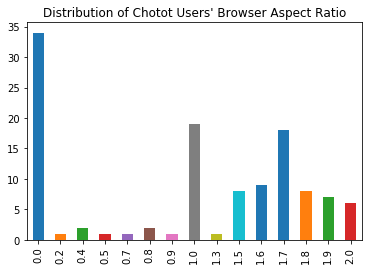

In [0]:
browser_ratio_series = pd.Series(browser_ratio_dict)
browser_ratio_series.sort_index().plot(kind='bar', \
                                       title='Distribution of Chotot Users\' Browser Aspect Ratio');

**Observation:** Events of type 'ADLISTING' have 'adlisting' as prefix of its name, the same goes for 'TINVIEW'. We decide to remove page_name from event_name.

In [0]:
print('Adlisting event:', data[data['page_name'] == 'ADLISTING']['event_name'].unique())
print('Adview event:', data[data['page_name'] == 'TINVIEW']['event_name'].unique())

Adlisting event: ['adlisting/CLASSIFYAD_LOAD' 'adlisting/ADVIEW_CLICK'
 'adlisting/STICKYAD_LOAD']
Adview event: ['adview/ADVIEW_LOAD' 'adview/CALL_CLICK' 'adview/CALL_CLICK_BODY'
 'adview/CHAT_CLICK' 'adview/SMS_CLICK' 'adview/SIMILARAD_LOAD'
 'adview/SHOW_PHONE_CLICK' 'adview/SHOW_PHONE_CLICK_BODY']


In [0]:
def remove_page_name(event_name):
    event_name = re.sub(pattern='^\w+/', repl='', string=event_name)
    return event_name

data['event_name'] = data['event_name'].apply(remove_page_name)

**Observation:** Inconsistent use of language within page_name values. Hence, we replace value 'TINVIEW' with 'ADVIEW'.

In [0]:
data['page_name'] = data['page_name'].replace(to_replace='TINVIEW', value='ADVIEW')

**Expectations:**  Not so many people paid for sticky advertisements, which means most of advertisements are classified/standard ones. It clearly explains why the number of 'classifyad' and 'CLASSIFYAD_LOAD' are dominant in behavior data.

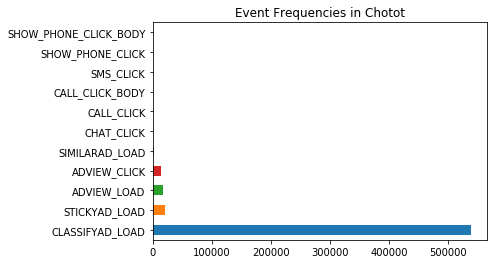

In [0]:
event_fre_data = data['event_name'].value_counts()
ax = event_fre_data.plot(kind='barh', title='Event Frequencies in Chotot');

In [0]:
data['event_name'].value_counts()

CLASSIFYAD_LOAD          539559
STICKYAD_LOAD             20829
ADVIEW_LOAD               18388
ADVIEW_CLICK              13422
SIMILARAD_LOAD             3071
CHAT_CLICK                  324
CALL_CLICK                  216
CALL_CLICK_BODY             170
SMS_CLICK                    74
SHOW_PHONE_CLICK             15
SHOW_PHONE_CLICK_BODY         7
Name: event_name, dtype: int64

**Question:** Which product category are users usually looking for?

**Observation:** Vehicles (2) and tech gadgets (5) are in high demand.

In [0]:
filter_category_id_dict = dict()

for idx, row in unique_data.iterrows():
    for category_id in row['filter_category_id']:
        i = category_id // 1000
        if i not in filter_category_id_dict:
            filter_category_id_dict[i] = 0
        filter_category_id_dict[i] += 1

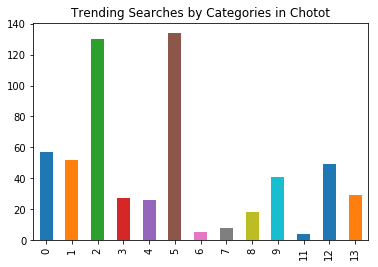

In [0]:
pd.Series(filter_category_id_dict).sort_index().plot(kind='bar', title='Trending Searches by Categories in Chotot');

**We decide to work on tech gadgets recommendation.**

In [0]:
tech_data = pd.read_csv('/home/rakul/Documents/data/null_normalized_data/tech_data/tech_ads_stats.csv', index_col=0)
tech_data.head()

,adlist_id,adplacement,adposition,adsource,app_os_name,app_os_version,app_version,browser_viewheight,browser_viewwidth,event_client_time,...,filter_price,filter_region_id,filter_type,lead_type,page_name,page_number,page_platform,page_referer,tagging_key,user_fingerprint
0,62548762,default,13,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:05:19.000,...,NaN,3017,NaN,NaN,ADLISTING,4,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
2,62547636,default,3,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:07:48.000,...,NaN,3017,NaN,NaN,ADLISTING,7,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
3,62546151,default,19,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-09-07 19:08:53.000,...,NaN,3017,NaN,NaN,ADLISTING,10,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
16,61540617,default,15,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-08-25 11:08:13.000,...,NaN,3017,NaN,NaN,ADLISTING,1,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631
17,62046088,default,6,classifyad,NaN,12.1.4,3.6.9059,667,667,2019-08-25 11:08:37.000,...,NaN,3017,NaN,NaN,ADLISTING,2,IOS,NaN,B,3618f309-2641-4646-ae4f-c3a7443df631


**Observation:** We may think that load events do not indicate any user interest in the advertisement for the fact that these events are automatically created when they scroll over a list of items. However, we can extract some useful insights into user specific needs on the basis of filter parameters they specified, which were recorded in load events.

In [0]:
tech_data.columns

Index(['adlist_id', 'adplacement', 'adposition', 'adsource', 'app_os_name',
       'app_os_version', 'app_version', 'browser_viewheight',
       'browser_viewwidth', 'event_client_time', 'event_name',
       'event_server_time', 'event_type', 'filter_brand', 'filter_category_id',
       'filter_keyword', 'filter_model', 'filter_price', 'filter_region_id',
       'filter_type', 'lead_type', 'page_name', 'page_number', 'page_platform',
       'page_referer', 'tagging_key', 'user_fingerprint'],
      dtype='object')

In [0]:
def get_category_brand(row):
    brand = row['filter_brand']
    category = row['filter_category_id']
    return int(category * 10 + brand)

tech_data['category_brand'] = tech_data[['filter_category_id', 'filter_brand']]. \
                                fillna(0).apply(get_category_brand, axis=1)

In [0]:
pivot_category_data = tech_data.pivot_table(index=['filter_category_id', 'category_brand'], \
                                       values='user_fingerprint', aggfunc=pd.Series.nunique)

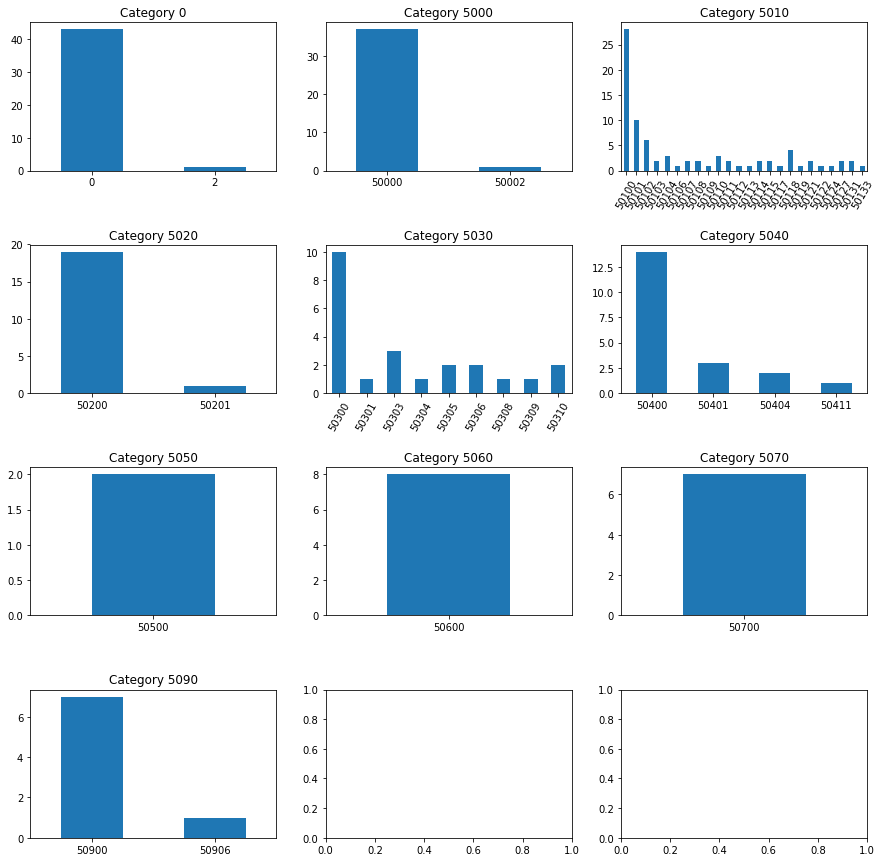

In [0]:
nrow, ncol = 4, 3
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(nrows=nrow, ncols=ncol, wspace=0.2, hspace=0.5)
axes = [fig.add_subplot(grid[i, j]) for i in range(nrow) for j in range(ncol)]
i = 0

for category_id in pivot_category_data.index.get_level_values(level=0).unique():
    df = pivot_category_data.xs(category_id)
    rotate_angle = (0 if df.shape[0] < 5 else 60)
    df.plot(kind='bar', legend=False, ax=axes[i], rot=rotate_angle, title='Category {}'.format(category_id))
    axes[i].set_xlabel('')
    i += 1

In [0]:
tech_data[['event_client_time', 'event_server_time']] = \
                            tech_data[['event_client_time', 'event_server_time']].apply(pd.to_datetime)

### Sessionazation

In [0]:
session_time = datetime.timedelta(seconds=60 * 30)

In [0]:
event_timestamp = tech_data[['event_client_time', 'user_fingerprint']]
event_timestamp['previous_time'] = event_timestamp.groupby(by='user_fingerprint')['event_client_time']. \
                                                    transform(lambda row : row.shift(1))
event_timestamp['new_session'] = (event_timestamp['event_client_time'] - event_timestamp['previous_time'] >= session_time). \
                                                    astype(int)
event_timestamp['increment'] = event_timestamp.groupby(by='user_fingerprint').cumsum()

In [0]:
tech_data['session_id'] = event_timestamp['increment'].astype(str) + '_' + ['user_fingerprint']

In [0]:
session_count = tech_data['session_id'].value_counts()

In [0]:
tech_data['click_dummy'] = (tech_data['event_type'] == 'CLICK')

In [0]:
count_click = tech_data[['click_dummy', 'session_id']].groupby(by='session_id').count()